In [1]:
import gymnasium as gym
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

Example from docs, just to make sure we can access the environment

In [2]:

env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

Simple model first. The inputs are an 8 dimensional vector, and the outputs are 4 dimensional vector. The model is a simple 2 layer MLP with 32 hidden units.

In [3]:
hidden_size = 32
class SimplePilot(nn.Module):
    def __init__(self, max_coords):
        super().__init__()
        self.max_coords= torch.tensor(max_coords, dtype=torch.float32)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, hidden_size),
            nn.ReLU(),
            #nn.Linear(hidden_size, hidden_size),
            #nn.ReLU(),
            nn.Linear(hidden_size, 4),
        )

    def forward(self, x):
        # normalize the input
        x = x / self.max_coords
        logits = self.linear_relu_stack(x)
        return logits

Quick test

In [4]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
max_coords = env.observation_space.high
pilot = SimplePilot(max_coords)
observation, info = env.reset()
observation = torch.tensor(observation, dtype=torch.float32)
probs = nn.functional.softmax(pilot(observation),dim=0)
# sample from the distribution
action = torch.multinomial(probs, 1).item()
observation, reward, terminated, truncated, info = env.step(action)
print(f"Action: {action}, Reward: {reward}")
env.close()

Action: 2, Reward: -1.0536370932811565


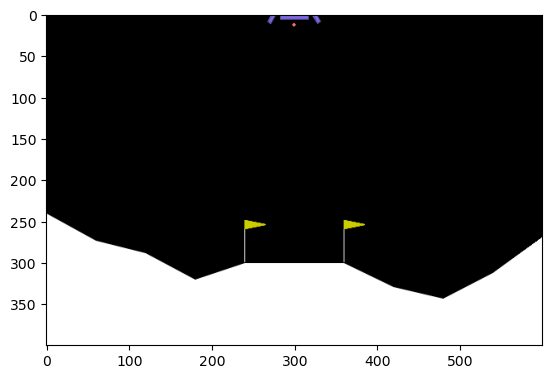

In [5]:
plt.imshow(env.render())

Now we are ready to start building the policy gradient training. I used "Hands on Machine Learning ..." by Geron as a rough guide (the code in the book uses tensorflow and is for the cart pole problem.) I will refer to this as HOML.

In [6]:
def play_one_step(env, obs, model, loss_fn):
    model.zero_grad()
    obs = torch.tensor(obs, dtype=torch.float32)
    logits = model(obs)
    probs = nn.functional.softmax(logits, dim=0)
    action = torch.multinomial(probs, 1).item()
    one_hot_action = torch.nn.functional.one_hot(torch.tensor(action), num_classes=4)
    #Compute gradient assuming chosen action was correct
    loss = loss_fn(logits, one_hot_action.float())
    loss.backward()
    grads = [param.grad for param in model.parameters()]
    action = torch.multinomial(probs, 1).item()
    next_obs, reward, terminated, truncated, info = env.step(action)
    return next_obs, reward, terminated, truncated, grads

In [7]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
max_coords = env.observation_space.high
pilot = SimplePilot(max_coords)
observation, info = env.reset()
next_obs, reward, terminated, truncated, grads = play_one_step(env,
                                     observation, pilot, nn.CrossEntropyLoss())
print(len(grads))
env.close()

4


Code copied directly from HOML

In [8]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

Test

In [75]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
max_coords = env.observation_space.high
pilot = SimplePilot(max_coords)
observation, info = env.reset()
all_rewards, all_grads = play_multiple_episodes(env, 3, 1000, pilot, nn.CrossEntropyLoss())
env.close()

Ok so this returns two lists with the rewards and gradients for each episode. Now we need discount the rewards, and normalize them so that they have mean 0 and std 1. This is a standard trick to make the training more stable.  This code is copied from HOML

In [9]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Ok lets try training this

In [12]:
n_iterations = 500
n_episodes_per_update = 50
n_max_steps = 1000
discount_factor = 0.95
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pilot.parameters(), lr=0.01)

Initialize the pilot and environment

In [11]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
max_coords = env.observation_space.high
pilot = SimplePilot(max_coords)


Compute mean total rewards for the multiple episodes

In [23]:
def net_rewards(all_rewards):
    return np.mean([sum(rewards) for rewards in all_rewards])

In [25]:
# Training loop
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, pilot, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for var_index, param in enumerate(pilot.parameters()):
        mean_grads = torch.mean(
            torch.stack([final_reward * all_grads[episode_index][step][var_index]
                         for episode_index, final_rewards in enumerate(all_final_rewards)
                             for step, final_reward in enumerate(final_rewards)]), dim=0)
        all_mean_grads.append(mean_grads)
    optimizer.zero_grad()
    for grad, param in zip(all_mean_grads, pilot.parameters()):
        param.grad = grad
    optimizer.step()
    if iteration % 50 == 0:
        print(f"Iteration: {iteration}, Mean Reward: {net_rewards(all_rewards)}")


Iteration: 0, Mean Reward: -217.39327573364395
Iteration: 50, Mean Reward: -283.9711714782008
Iteration: 100, Mean Reward: -171.88047843245238
Iteration: 150, Mean Reward: -297.76440726508514
Iteration: 200, Mean Reward: -300.2797707764365
Iteration: 250, Mean Reward: -464.2502719866481
Iteration: 300, Mean Reward: -643.3567520771923
Iteration: 350, Mean Reward: -568.0402634351217
Iteration: 400, Mean Reward: -628.1072562617858
Iteration: 450, Mean Reward: -476.16152458567404
Iteration: 500, Mean Reward: -482.0020959861792
Iteration: 550, Mean Reward: -308.8508794210924
Iteration: 600, Mean Reward: -253.55425354991445
Iteration: 650, Mean Reward: -226.29005776053273
Iteration: 700, Mean Reward: -339.25849741442784
Iteration: 750, Mean Reward: -182.74897568736532
Iteration: 800, Mean Reward: -207.84142963938484
Iteration: 850, Mean Reward: -208.5495329528449
Iteration: 900, Mean Reward: -199.02912261944246
Iteration: 950, Mean Reward: -197.93463664289294


In [31]:
env.close()

env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()
with torch.no_grad():
    for _ in range(1000):
        logits = pilot(torch.tensor(observation, dtype=torch.float32))
        probs = nn.functional.softmax(logits, dim=0)
        action = torch.multinomial(probs, 1).item()
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            observation, info = env.reset()

env.close()

In [94]:
nn.functional.softmax(pilot(torch.tensor(observation, dtype=torch.float32)),dim=0)

tensor([0.2746, 0.2482, 0.2018, 0.2755], grad_fn=<SoftmaxBackward0>)

In [30]:
env.close()